<a href="https://colab.research.google.com/github/pinholuc/mlops/blob/master/ml_handbook/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

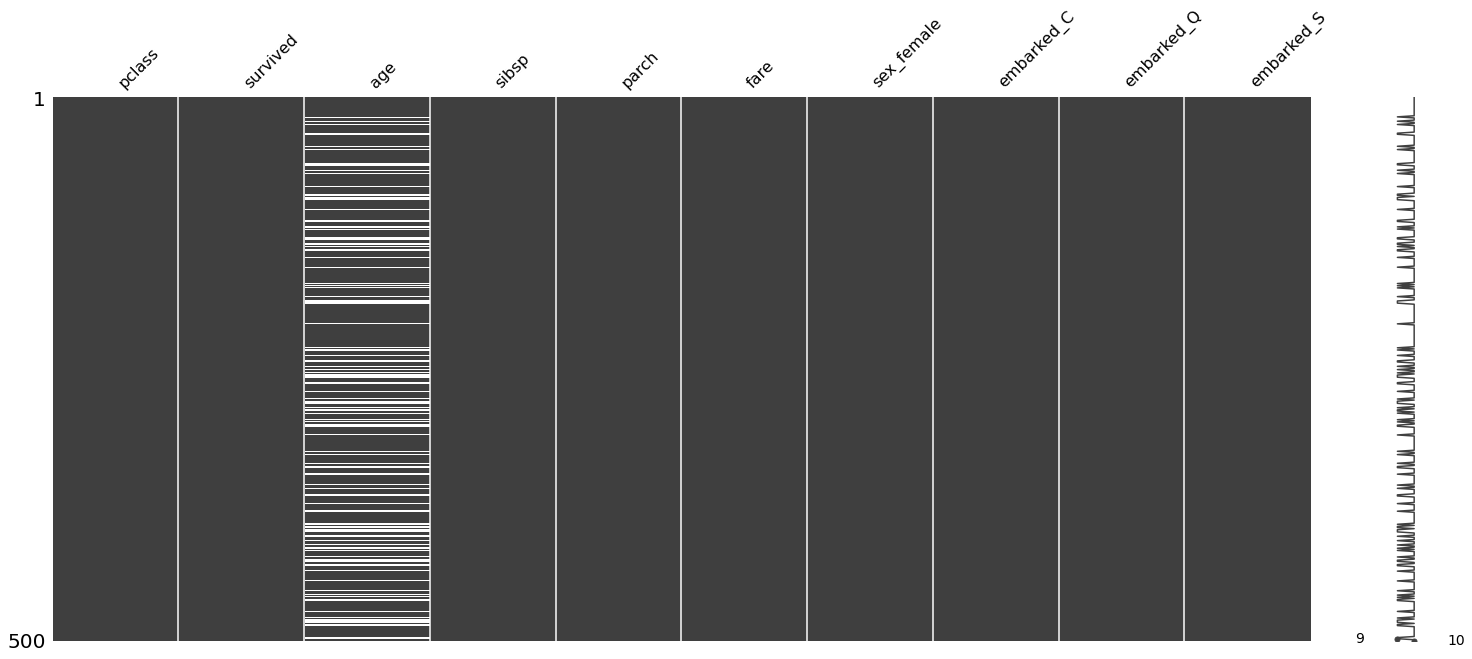

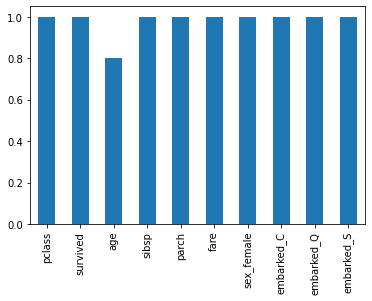

In [13]:
"""
A grande maioria dos algoritmos nao lida bem com dados ausentes. Excecoes dignas
de nota sao as libs XGBoost, CatBoost e LightGBM

Existem algumas abordagens para lidar com dados ausentes:

  * remover qualquer linha com dados ausentes
  * remover qualquer coluna com dados ausentes
  * imputar dados aos valores ausentes
  * criar uma coluna para informar que os dados estavam ausentes
"""
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd

df = pd.read_excel('../titanic3.xls')
# Droping features that are not useful to our model
df = df.drop(columns = ["name", 
                        "ticket", 
                        "home.dest", 
                        "boat", 
                        "body", 
                        "cabin"])
# Getting rid of string/object features
df = pd.get_dummies(df).drop(columns="sex_male")

# Segregate features (x) and labels (y)
X = df.drop(columns="survived")

# Labels (y)
y = df.survived

ax = msno.matrix(df.sample(500))
ax.get_figure().savefig("missing_data.png")

fig, ax = plt.subplots(figsize=(6,4))
(1 - df.isnull().mean()).abs().plot.bar(ax=ax)
fig.savefig("missing_data_matrix.png")




In [10]:
# Descartando dados ausentes

"""
dropna descarta todas as linhas contendo dados ausentes
"""

clean_rows = df.dropna() # drop todas linhas com valor null
clean_columns = df.dropna(axis=1) # drop no eixo das colunas

In [12]:
# Imputando dados ausentes

"""
A classe SimpleImputer do scikit-learn trabalhara com a media, mediana e com 
valores mais frequentes dos atributos.

Especificamos a strategy='median' ou strategy='most_frequent' para substituir
o valor usado na substituicao pela mediana ou pelo valor mais comum,
respectivamente.
"""
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include="number").columns
im = SimpleImputer()
imputed = im.fit_transform(df[num_cols])

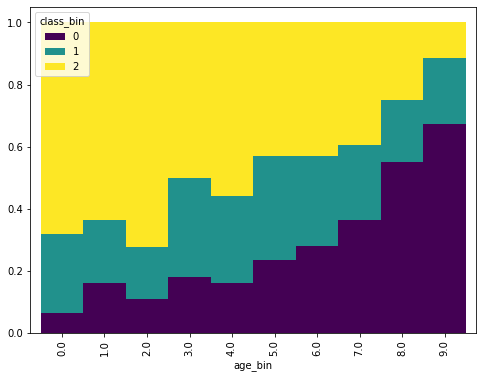

In [15]:
# Exploring

"""
Comparando dois atributos categoricos
"""

fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(X.age, q=10, labels=False),
        class_bin=pd.cut(X.pclass, bins=3, labels=False),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis"
    )
)

fig.savefig("eda_01.png", dpi=300, bbox_inches="tight")


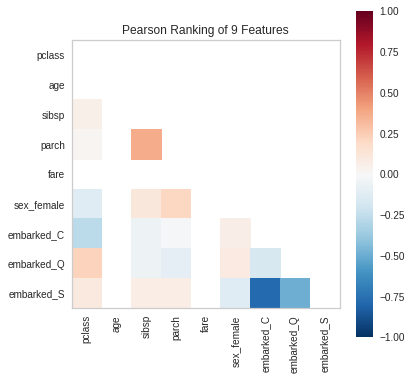

In [16]:
"""
Yellowbrick eh capaz de fazer comparacoes aos pares entre os atributos.
Um exemplo eh a correlacao de Pearson (que tambem poderia spearman ou covariance)
"""

from yellowbrick.features import Rank2D
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(features=X.columns, algorithm="pearson")
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()
fig.savefig("correlation_pearson.png", dpi=300, bbox_inches="tight")

In [18]:
# Preprocessing

"""
One-Hot Encoding: pode ser utilizado para transformar atributos categoricos em 
valores numericos
"""

X_cat = pd.DataFrame(
    {
        "name": ["George", "Paul"],
        "inst": ["bass", "guitar"]
    }
)

pd.get_dummies(X_cat, drop_first=True)

,name_Paul,inst_guitar
0,0,0
1,1,1


In [20]:
"""
Label Encoding: util quando temos dados categoricos com elevada cardinalidade.
Neste caso, cada dado de categoria sera atribuido a um numero. Eh um metodo
conveniente para dados com alta cardinalidade. Menos espaco podera ser ocupado
em comparacao com one-hot encoding e alguns algoritmos (de arvore) sao capazes
de lidar com essa codificacao
"""

from sklearn import preprocessing 

lab = preprocessing.LabelEncoder()
lab.fit_transform(X_cat["name"])

array([0, 1])

In [22]:
"""
Frequency encoding: outra opcao para lidar com alta cardinalidade.
Isso significa substituir o nome da categoria pelo contador que ela tinha
nos dados de treinamento. 
"""

mapping = X_cat.name.value_counts()
X_cat.name.map(mapping)

0    1
1    1
Name: name, dtype: int64